In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel, MultiModel
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# make experiments reproducable
import torch as t
t.manual_seed(0)

# globals
SYMBOL = "T"
START_DATE = "1995-01-01"
MODEL_REPOSITORY = "/home/kic/models"

automatically imported pandas_ml_utils 0.1.5


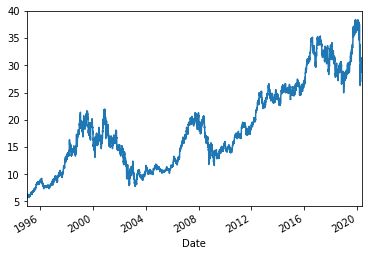

In [2]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)
df["Close"].plot()

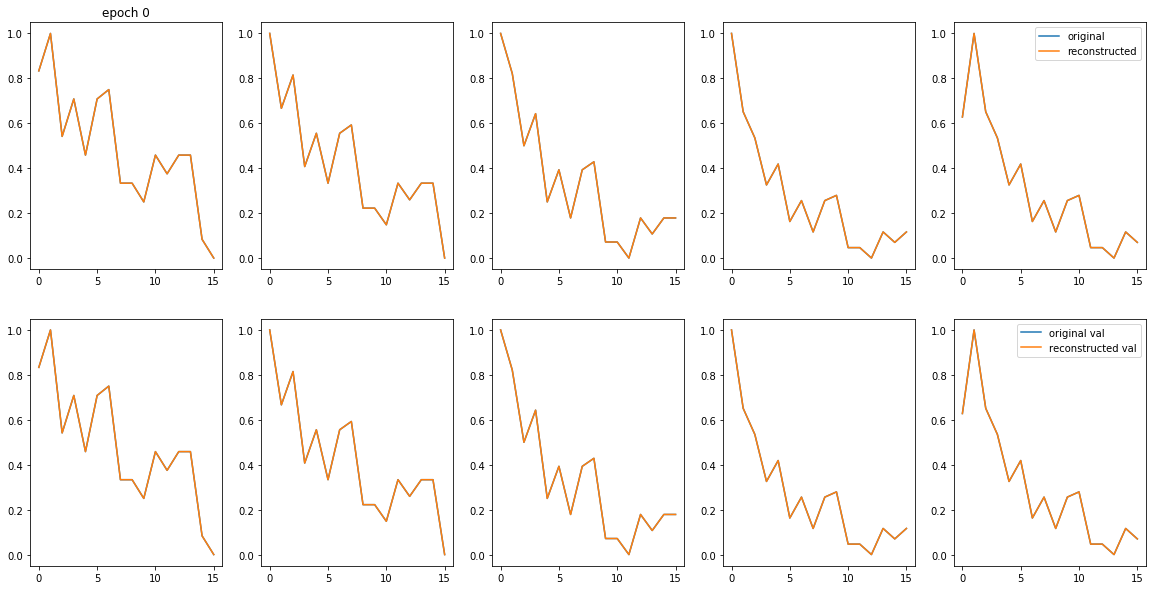

,Close_gaf
Date,
2020-05-01,"[[-0.9037380258225742, -0.7271680015293189, 0...."
2020-05-04,"[[-0.9912015826738856, -0.958938135695799, -0...."
2020-05-05,"[[-0.9620470637234488, -0.9791484670551369, -0..."
2020-05-06,"[[-1.0, -0.9330107544676267, -0.95176814577174..."
2020-05-07,"[[-0.9971303948576675, -0.9992823411973384, -0..."


In [3]:
from IPython.display import clear_output

def inverse_gaf(values):
    values = values[0] # use first channel
    return np.sqrt(((np.diag(values) + 1) / 2))
    
def plot_callback(y, y_hat, y_val, y_hat_val, epoch):
    clear_output(wait=True)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))    
    ax[0, 0].set_title(f'epoch {epoch}')

    for i in range(5):
        _y = inverse_gaf(y[i])
        _y_hat = inverse_gaf(y_hat[i])

        _y_val = inverse_gaf(y_val[i])
        _y_hat_val = inverse_gaf(y_hat_val[i])
        
        ax[0, i].plot(_y, label="original")
        ax[0, i].plot(_y_hat, label="reconstructed")
        ax[1, i].plot(_y_val, label="original val")
        ax[1, i].plot(_y_hat_val, label="reconstructed val")
        
    ax[0, -1].legend()
    ax[1, -1].legend()
    plt.show()
            
f_n_l = FeaturesAndLabels(
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    targets = [lambda df: df["Close"] > df["Close"].shift(16)]
)

(f, _), l, t, w, gl = df._.extract(f_n_l)
label = l._.values

# plot and simulate a batch
plot_callback(label[:10], label[:10], label[:10], label[:10], 0)

f.tail()

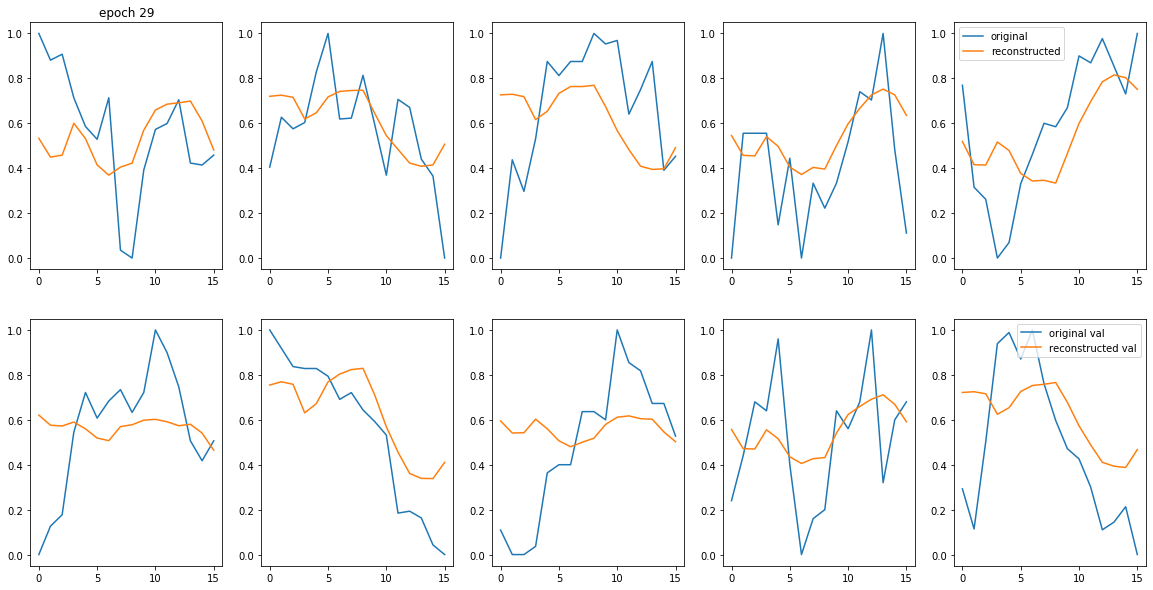

In [4]:
import torch as t
import torch.nn as nn
from torch.optim import Adam, Adagrad, RMSprop
from pandas_ml_utils import FeaturesAndLabels, PytorchModel, AutoEncoderModel
from pandas_ml_utils.pytorch import Reshape
from pandas_ml_quant.pytorch.custom_loss import SoftDTW

def auto_encoder_provider():
    class AutoEncoder(nn.Module):
        # conv2D: in_channels, out_channels, kernel_size, stride=1, padding=0,
        # out = (input - kernel + 2padding) / stride
        def __init__(self, activation = nn.Tanh):
            super().__init__()
            self.activation = activation

            self._encoder = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1),  # 16 - 3 + 2*1 / 1 + 1 => (?, 16, 16)
                activation(),
                nn.MaxPool2d(2, 2),              # (16 - 2) / 2 +1 => 8
                nn.Conv2d(16, 4, 3, padding=1),
                activation(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(4, 1, 3, padding=1),
                activation(),
                nn.MaxPool2d(2, 2),

                nn.Flatten()            
            )

            self._decoder = nn.Sequential(            
                Reshape(1, 2, 2),

                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(1, 4, 3, padding=1),
                activation(),

                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(4, 16, 3, padding=1),
                activation(),
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(16, 1, 3, padding=1),
                nn.Tanh()
            )

        def forward(self, x):
            _x = nn.Dropout(0.1)(x) if self.training else x
            _x = self._encoder(_x)
            _x = self._decoder(_x)
            return _x

        def encoder(self, x):
            with t.no_grad():
                return self._encoder(t.from_numpy(x).float()).numpy()

        def decoder(self, x):
            with t.no_grad():
                return self._decoder(t.from_numpy(x).float()).numpy()

    return AutoEncoder()


model = AutoEncoderModel(
    PytorchModel(
        FeaturesAndLabels(
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True).shift(-8)],
        ),
        auto_encoder_provider,
        nn.MSELoss,
        Adam,
    ),
    [f"condensed{i}" for i in range(4)],
    lambda m: m.module.encoder,
    lambda m: m.module.decoder,
)

model().save("/tmp/foo.test")

ae_fit = df.model.fit(
    model, 
    epochs=30, 
    batch_size=32, 
    on_epoch=[plot_callback]
)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aab09f1d0>)

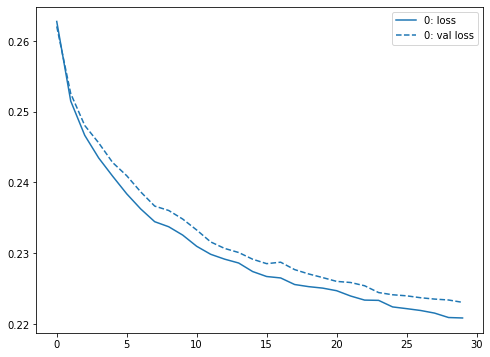

In [5]:
ae_fit.model.plot_loss()

In [10]:
encoder_model = ae_fit.model.as_encoder()
encoder_model.save(f"{MODEL_REPOSITORY}/{SYMBOL}-ConvAE.model")
encoded_df = df.model.predict(encoder_model.as_encoder())
encoded_df.tail()

saved model to: /home/kic/models/T-ConvAE.model


prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-05-01   0.200092  -0.001717  -0.016505   0.401941   
2020-05-04   0.324016   0.089808  -0.183419   0.258450   
2020-05-05   0.461329   0.163286  -0.030649   0.347903   
2020-05-06   0.536949   0.282535  -0.002106  -0.266770   
2020-05-07   0.526014   0.208441   0.180655  -0.417756   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-05-01  [[-0.9037380258225742, -0.7271680015293189, 0....  
2020-05-04  [[-0.9912015826738856, -0.958938135695799, -0....  
2020-05-05  [[-0.9620470637234488, -0.9791484670551369, -0...  
2020-05-06  [[-1.0, -0.9330107544676267, -0.95176814577174...  
2020-05-07  [[-0.9971303948576675, -0.9992823411973384, -0...

In [6]:
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_quant.model.summary import BinaryWeightedClassificationSummary


sfit = df.model.fit(
    SkModel(
        MLPClassifier(
            activation='tanh', 
            hidden_layer_sizes=(50, 40), 
            random_state=42, 
            max_iter=120,
            alpha=0.02,
            warm_start=True
        ),
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df, ae_model: df.ta.model(ae_model),
                # lambda df: df["Close"].ta.macd(),
                # lambda df: df.ta.atr(),
                # lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']],
                lambda df: (df["Volume"] / df["Volume"].ta.sma(20)).rename("Volume")
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(200)
            ],
            labels=[
                lambda df: df["Close"].shift(-7) > df["Close"].ta.sma(20)
            ],
            targets=[
                lambda df: df["Close"].ta.sma(20),
            ],
            gross_loss=[
                lambda df: df["Close"].shift(-7) - df["Close"].ta.sma(20)
            ],
            ae_model=encoder_model
        ),
        summary_provider=BinaryWeightedClassificationSummary
    ),
    RandomSplits(
        test_size=0.2,
        youngest_size=0.05,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=7).split)
    )
)

sfit

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return df.loc[value]

  % self.max_iter, ConvergenceWarning)



Training Data,Test Data


In [7]:
df.model.predict(sfit.model, tail=2)

target prediction         feature                  \
           Close_sma_20          0 (0, condensed0) (1, condensed0)   
Date                                                                 
2020-05-04      30.2015   0.998250        0.241401        0.068077   
2020-05-05      30.2420   0.960521        0.288133        0.241401   

                                                                            \
           (2, condensed0) (3, condensed0) (4, condensed0) (5, condensed0)   
Date                                                                         
2020-05-04       -0.126412       -0.449651       -0.106136        0.048871   
2020-05-05        0.068077       -0.126412       -0.449651       -0.106136   

                                            ...                              \
           (6, condensed0) (7, condensed0)  ... (190, Volume) (191, Volume)   
Date                                        ...                               
2020-05-04        0.189921        0.187136  ...      1.292970      1.323172   
2020-05-05        0.048871        0.189921  ...      1.127414      1.292970   

                                                                    \
           (192, Volume) (193, Volume) (194, Volume) (195, Volume)   
Date                                                                 
2020-05-04      1.130543      1.033576      1.122386      1.295140   
2020-05-05      1.323172      1.130543      1.033576      1.122386   

                                                                    
           (196, Volume) (197, Volume) (198, Volume) (199, Volume)  
Date                                                                
2020-05-04      1.632648      1.620612      1.318802      1.185923  
2020-05-05      1.295140      1.632648      1.620612      1.318802  

[2 rows x 1002 columns]

In [20]:
from torch.optim import Adam, AdamW
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_quant.model.summary import BinaryWeightedClassificationSummary

def module_provider():
    
    class FNN(nn.Module):
        
        def __init__(self):
            super().__init__()
            nr_features = 14
            self.model = nn.Sequential(
                Reshape(200 * nr_features),
                nn.Linear(200 * nr_features, 30),
                nn.Dropout(0.33),
                nn.Tanh(),
                nn.Linear(30, 20),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(20, 20),
                nn.Dropout(0.1),
                #nn.Tanh(),
                nn.LeakyReLU(),
                nn.Linear(20, 1),
                nn.Dropout(0.0001),
                nn.Sigmoid()
            )
            
        def forward(self, x):
            #x = nn.Dropout(0.1)(x) if self.training else x
            return self.model(x)
        
    return FNN()


tfit = df.model.fit(
    PytorchModel(
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df, ae_model: df.ta.model(ae_model),
                lambda df: df["Close"].ta.macd(),
                lambda df: df.ta.atr(),
                lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']],
                lambda df: (df["Volume"] / df["Volume"].ta.sma(20)).rename("Volume"),
                lambda df: df["Close"].ta.stddev(20)
                # lambda df: df.ta.candle_category() / 15
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(200)
            ],
            labels=[
                lambda df: df["Close"].shift(-7) > df["Close"].ta.sma(20)
            ],
            targets=[
                lambda df: df["Close"].ta.sma(20),
            ],
            gross_loss=[
                lambda df: df["Close"].shift(-7) - df["Close"].ta.sma(20)
            ],
            sample_weights=[
                lambda df: (((np.log(df["Close"]).shift(-7) - np.log(df["Close"].ta.sma(20)) + 1).abs() * 2) ** 8).rename("sample_weight")
            ],
            ae_model=encoder_model
        ),
        module_provider,
        lambda: nn.BCELoss(reduction='none'),
        lambda p: Adam(p, weight_decay=0.0001),
        summary_provider=BinaryWeightedClassificationSummary
    ),
    RandomSplits(
        test_size=0.2,
        youngest_size=0.05,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=5).split)
    ),
    epochs=10,
    batch_size=32,
    on_epoch=[PytorchModel.Callbacks.early_stopping(patience=20)]
)

tfit

Training Data,Test Data


In [21]:
df = pd.fetch_yahoo(SYMBOL)
df.model.predict(tfit.model, tail=4)

target prediction         feature                  \
           Close_sma_20          0 (0, condensed0) (1, condensed0)   
Date                                                                 
2020-05-01      30.0710   0.971668        0.068077       -0.126412   
2020-05-04      30.2015   0.110253        0.241401        0.068077   
2020-05-05      30.2420   0.719369        0.288133        0.241401   
2020-05-06      30.2035   0.353538        0.396291        0.288133   

                                                                            \
           (2, condensed0) (3, condensed0) (4, condensed0) (5, condensed0)   
Date                                                                         
2020-05-01       -0.449651       -0.106136        0.048871        0.189921   
2020-05-04       -0.126412       -0.449651       -0.106136        0.048871   
2020-05-05        0.068077       -0.126412       -0.449651       -0.106136   
2020-05-06        0.241401        0.068077       -0.126412       -0.449651   

                                            ...                         \
           (6, condensed0) (7, condensed0)  ... (190, Close_stddev_20)   
Date                                        ...                          
2020-05-01        0.187136        0.223243  ...               0.005780   
2020-05-04        0.189921        0.187136  ...               0.005936   
2020-05-05        0.048871        0.189921  ...               0.006070   
2020-05-06       -0.106136        0.048871  ...               0.006055   

                                                          \
           (191, Close_stddev_20) (192, Close_stddev_20)   
Date                                                       
2020-05-01               0.005648               0.005509   
2020-05-04               0.005780               0.005648   
2020-05-05               0.005936               0.005780   
2020-05-06               0.006070               0.005936   

                                                          \
           (193, Close_stddev_20) (194, Close_stddev_20)   
Date                                                       
2020-05-01               0.005126               0.005067   
2020-05-04               0.005509               0.005126   
2020-05-05               0.005648               0.005509   
2020-05-06               0.005780               0.005648   

                                                          \
           (195, Close_stddev_20) (196, Close_stddev_20)   
Date                                                       
2020-05-01               0.005507               0.005975   
2020-05-04               0.005067               0.005507   
2020-05-05               0.005126               0.005067   
2020-05-06               0.005509               0.005126   

                                                          \
           (197, Close_stddev_20) (198, Close_stddev_20)   
Date                                                       
2020-05-01               0.005975               0.006105   
2020-05-04               0.005975               0.005975   
2020-05-05               0.005507               0.005975   
2020-05-06               0.005067               0.005507   

                                   
           (199, Close_stddev_20)  
Date                               
2020-05-01               0.006470  
2020-05-04               0.006105  
2020-05-05               0.005975  
2020-05-06               0.005975  

[4 rows x 2802 columns]

In [10]:
tfit.model.save(f"/home/kic/models/{SYMBOL}-ConveAE-PyTorchFNN-t+7.model")

saved model to: /home/kic/models/T-ConveAE-PyTorchFNN-t+7.model


In [11]:
pdf = df.model.predict(tfit.model)

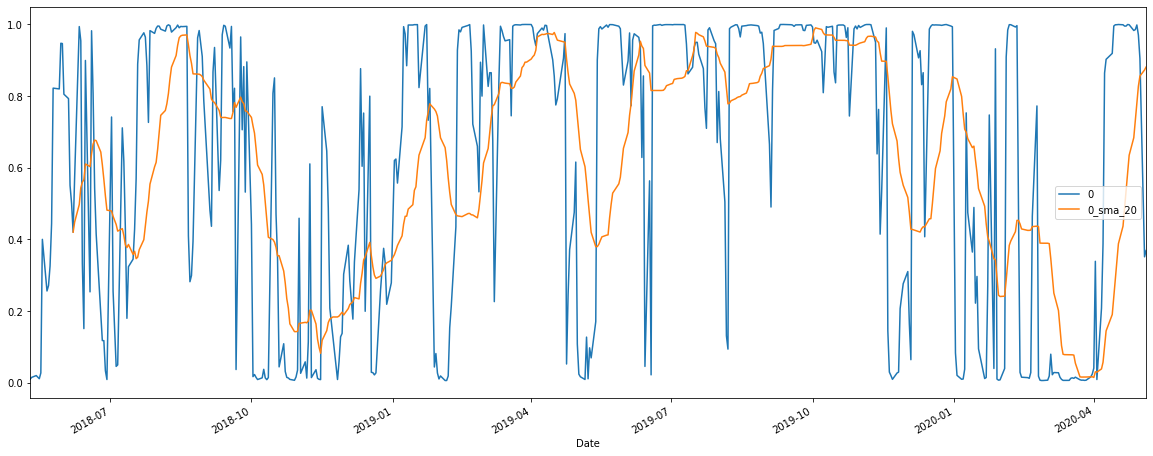

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
pdf["prediction"][-500:].plot(ax=ax)
pdf["prediction"][-500:].ta.sma(20).plot(ax=ax)


In [23]:
iyz = pd.fetch_yahoo("iyz")
bt = iyz.model.backtest(tfit.model, BinaryWeightedClassificationSummary)
bt

In [17]:
iyz.model.predict(tfit.model, tail=2)

target prediction         feature                  \
           Close_sma_20          0 (0, condensed0) (1, condensed0)   
Date                                                                 
2020-05-04      26.8115   0.863570        0.348639        0.200348   
2020-05-05      26.8640   0.792358        0.314366        0.348639   

                                                                            \
           (2, condensed0) (3, condensed0) (4, condensed0) (5, condensed0)   
Date                                                                         
2020-05-04       -0.035915       -0.459696       -0.248101       -0.168225   
2020-05-05        0.200348       -0.035915       -0.459696       -0.248101   

                                            ...                              \
           (6, condensed0) (7, condensed0)  ... (190, Volume) (191, Volume)   
Date                                        ...                               
2020-05-04        0.067466        0.043658  ...      1.346883      0.482307   
2020-05-05       -0.168225        0.067466  ...      0.427345      1.346883   

                                                                    \
           (192, Volume) (193, Volume) (194, Volume) (195, Volume)   
Date                                                                 
2020-05-04      0.170803      0.332952      0.213280      0.180109   
2020-05-05      0.482307      0.170803      0.332952      0.213280   

                                                                    
           (196, Volume) (197, Volume) (198, Volume) (199, Volume)  
Date                                                                
2020-05-04      0.154552      1.665615      1.430042      1.748604  
2020-05-05      0.180109      0.154552      1.665615      1.430042  

[2 rows x 2602 columns]

In [12]:
from functools import partial
from torch.optim import Adam, AdamW
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_quant.model.summary import MultipleBinaryWeightedClassificationSummary


def module_provider():
    
    class FNN(nn.Module):
        
        def __init__(self):
            super().__init__()
            nr_features = 14
            self.model = nn.Sequential(
                Reshape(200 * nr_features),
                nn.Linear(200 * nr_features, 32),
                nn.Dropout(0.33),
                nn.Tanh(),
                nn.Linear(32, 22),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(22, 22),
                #nn.Dropout(0.1),
                #nn.Tanh(),
                nn.LeakyReLU(),
                nn.Linear(22, 5),
                #nn.Dropout(0.0001),
                nn.Sigmoid()
            )
            
        def forward(self, x):
            #x = nn.Dropout(0.1)(x) if self.training else x
            return self.model(x)
        
    return FNN()


tfitm = df.model.fit(
    PytorchModel(
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df, ae_model: df.ta.model(ae_model),
                lambda df: df["Close"].ta.macd(),
                lambda df: df.ta.atr(),
                lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']],
                lambda df: (df["Volume"] / df["Volume"].ta.sma(20)).rename("Volume"),
                lambda df: df["Close"].ta.stddev(20)
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(200)
            ],
            labels=[
                partial(lambda i, df: (df["Close"].shift(-i) > df["Close"].ta.sma(20)).rename(f"label_{i}"), i) for i in range(5, 10)
            ],
            targets=[
                lambda df: df["Close"].ta.sma(20),
            ],
            gross_loss=[
                partial(lambda i, df: (df["Close"].shift(-i) - df["Close"].ta.sma(20)).rename(f"gl_{i}"), i) for i in range(5, 10)
            ],
            sample_weights=[
                partial(lambda i, df: (((np.log(df["Close"]).shift(-i) - np.log(df["Close"].ta.sma(20)) + 1).abs() * 2) ** 8).rename(f"sample_weight_{i}"), i) for i in range(5, 10)
            ],
            ae_model=encoder_model
        ),
        module_provider,
        lambda: nn.BCELoss(reduction='none'),
        lambda p: Adam(p, weight_decay=0.0001),
        summary_provider=MultipleBinaryWeightedClassificationSummary
    ),
    RandomSplits(
        test_size=0.2,
        youngest_size=0.05,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=5).split)
    ),
    batch_size=32,
    epoch=30,
    #on_epoch=[PytorchModel.Callbacks.early_stopping(patience=3), PytorchModel.Callbacks.print_loss(2)]
    #on_epoch=[PytorchModel.Callbacks.early_stopping(patience=3), lambda epoch, loss, val_loss: print(f"{epoch}: {loss}\t {val_loss}") if epoch % 2 == 0 else None]
)

tfitm

KeyboardInterrupt: 

In [16]:
df = pd.fetch_yahoo(SYMBOL)
df.model.predict(tfitm.model, tail=4)

target prediction                                          \
           Close_sma_20    label_5   label_6   label_7   label_8   label_9   
Date                                                                         
2020-05-01      30.0710   0.999864  0.997873  0.913575  0.644929  0.988060   
2020-05-04      30.2015   0.049405  0.058026  0.036330  0.385120  0.510320   
2020-05-05      30.2420   0.993520  0.951816  0.980852  0.998017  0.001753   
2020-05-06      30.2185   0.929292  0.733709  0.995184  0.036995  0.085364   

                   feature                                                  \
           (0, condensed0) (1, condensed0) (2, condensed0) (3, condensed0)   
Date                                                                         
2020-05-01        0.068077       -0.126412       -0.449651       -0.106136   
2020-05-04        0.241401        0.068077       -0.126412       -0.449651   
2020-05-05        0.288133        0.241401        0.068077       -0.126412   
2020-05-06        0.332695        0.288133        0.241401        0.068077   

            ...                                                          \
            ... (190, Volume) (191, Volume) (192, Volume) (193, Volume)   
Date        ...                                                           
2020-05-01  ...      1.323172      1.130543      1.033576      1.122386   
2020-05-04  ...      1.292970      1.323172      1.130543      1.033576   
2020-05-05  ...      1.127414      1.292970      1.323172      1.130543   
2020-05-06  ...      1.136522      1.127414      1.292970      1.323172   

                                                                    \
           (194, Volume) (195, Volume) (196, Volume) (197, Volume)   
Date                                                                 
2020-05-01      1.295140      1.632648      1.620612      1.318802   
2020-05-04      1.122386      1.295140      1.632648      1.620612   
2020-05-05      1.033576      1.122386      1.295140      1.632648   
2020-05-06      1.130543      1.033576      1.122386      1.295140   

                                        
           (198, Volume) (199, Volume)  
Date                                    
2020-05-01      1.185923      1.196119  
2020-05-04      1.318802      1.185923  
2020-05-05      1.620612      1.318802  
2020-05-06      1.632648      1.620612  

[4 rows x 2606 columns]

In [ ]:
from functools import partial
from torch.optim import Adam, AdamW
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_quant.model.summary import BinaryWeightedClassificationSummary


# fixme, should be part of features and labels
forcasting_range=range(1, 11)
    
def module_provider():
    
    class FNN(nn.Module):
        
        def __init__(self):
            super().__init__()
            nr_features = 14
            self.model = nn.Sequential(
                Reshape(200 * nr_features),
                nn.Linear(200 * nr_features, 30),
                nn.Dropout(0.33),
                nn.Tanh(),
                nn.Linear(30, 20),
                nn.Dropout(0.2),
                nn.Tanh(),
                nn.Linear(20, 20),
                nn.Dropout(0.1),
                nn.LeakyReLU(),
                nn.Linear(20, 1),
                nn.Dropout(0.0001),
                nn.Sigmoid()
            )
            
        def forward(self, x):
            return self.model(x)
        
    return FNN()

tfitmm = df.model.fit(
    MultiModel(
        PytorchModel(
            PostProcessedFeaturesAndLabels(
                features=[
                    lambda df, ae_model: df.ta.model(ae_model),
                    lambda df: df["Close"].ta.macd(),
                    lambda df: df.ta.atr(),
                    lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']],
                    lambda df: (df["Volume"] / df["Volume"].ta.sma(20)).rename("Volume"),
                    lambda df: df["Close"].ta.stddev(20)
                ],
                feature_post_processor=[
                    lambda df: df.ta.rnn(200)
                ],
                labels=[
                    partial(lambda i, df: (df["Close"].shift(-i) > df["Close"].ta.sma(20)).rename(f"label_{i}"), i) for i in forcasting_range
                ],
                targets=[
                    lambda df: df["Close"].ta.sma(20),
                ],
                gross_loss=[
                    partial(lambda i, df: (df["Close"].shift(-i) - df["Close"].ta.sma(20)).rename(f"gl_{i}"), i) for i in forcasting_range
                ],
                sample_weights=[
                    partial(lambda i, df: (((np.log(df["Close"]).shift(-i) - np.log(df["Close"].ta.sma(20)) + 1).abs() * 2) ** 8).rename(f"sample_weight_{i}"), i) for i in forcasting_range
                ],
                ae_model=encoder_model,
            ),
            module_provider,
            lambda: nn.BCELoss(reduction='none'),
            lambda p: Adam(p, weight_decay=0.0001),
        ),
        len(forcasting_range),
        summary_provider=MultipleBinaryWeightedClassificationSummary
    ),
    RandomSplits(
        test_size=0.2,
        youngest_size=0.05,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=5).split)
    ),
    batch_size=32,
    epochs=30,
    #on_epoch=[PytorchModel.Callbacks.print_loss(2)]
    #on_epoch=[PytorchModel.Callbacks.early_stopping(patience=3), lambda epoch, loss, val_loss: print(f"{epoch}: {loss}\t {val_loss}") if epoch % 2 == 0 else None]
)

tfitmm